In [1]:
import sys
import math
from pathlib import Path
from collections import Counter, defaultdict
from dataclasses import dataclass, field
import warnings

warnings.filterwarnings("ignore")
sys.path.append("..\..")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

from src.data.structures.melody import Melody
from src.data.structures.note import Note
from src.data.datasets.melody_dataset import MelodyDataset

In [2]:
TITLE_FONTSIZE = 18
TICKS_FONTSIZE = 16

LABELS_FONTSIZE = 17
LABELS_PAD = 10

ENUM_FONTSIZE = 22
ENUM_PADDING = -0.25

LEGEND_FONTSIZE = 15

FIGSIZE = (20, math.ceil(7 + ENUM_PADDING))

In [3]:
dataset_path = Path("..\\..\\datasets\\MelodyNet\\raw\\")

train_path = dataset_path / "train"
val_path = dataset_path / "val"
test_path = dataset_path / "test"

In [4]:
@dataclass
class SectionStats:
    section_path: str | Path
    total_files: int = field(default=0)
    melody_durations: list[float] = field(default_factory=list)
    total_notes: int = field(default=0)
    total_rests: int = field(default=0)
    notes: list[str] = field(default_factory=list)
    octaves: list[int] = field(default_factory=list)
    note_durations: list[float] = field(default_factory=list)
    rest_durations: list[float] = field(default_factory=list)
    file_note_frequencies: dict = field(default_factory=lambda: defaultdict(list))

In [5]:
def get_section_stats(section_path: str | Path) -> SectionStats:
    midi_files = list(Path(section_path).rglob("*.mid"))
    section_stats = SectionStats(section_path=section_path, total_files=len(midi_files))
    
    note_classes = Note.PITCH_LABELS + ['REST']
    
    for midi_path in midi_files:
        melody = Melody.from_midi(midi_path)
        section_stats.melody_durations.append(melody.duration)
        
        file_notes = []
        
        for note in melody.notes:
            if note.is_rest:
                section_stats.total_rests += 1
                section_stats.notes.append('REST')
                section_stats.rest_durations.append(note.duration)
                file_notes.append('REST')
            else:
                section_stats.total_notes += 1
                note_class = note.note_name[:-1]
                section_stats.notes.append(note_class)
                section_stats.octaves.append(note.octave)
                section_stats.note_durations.append(note.duration)
                file_notes.append(note_class)
        
        total_notes_in_file = len(file_notes)
        if total_notes_in_file > 0:
            file_counts = Counter(file_notes)
            for note_class in note_classes:
                frequency = file_counts.get(note_class, 0) / total_notes_in_file * 100
                section_stats.file_note_frequencies[note_class].append(frequency)
    
    return section_stats

In [6]:
train_stats = get_section_stats(train_path)
val_stats = get_section_stats(val_path)
test_stats = get_section_stats(test_path)

stats_list = [(train_stats, 'train'), (val_stats, 'val'), (test_stats, 'test')]

In [7]:
sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set(font_scale = 1.2)

# Распределение количества файлов

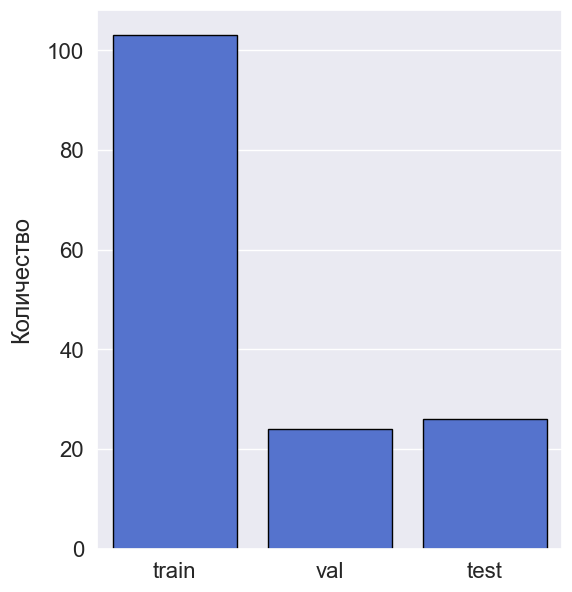

In [8]:
plt.figure(figsize=(FIGSIZE[0] // 3, FIGSIZE[1]))

rests_df = pd.DataFrame({
    'раздел': ['train', 'val', 'test'],
    'количество': [train_stats.total_files, val_stats.total_files, test_stats.total_files]
})

ax = sns.barplot(
    data=rests_df, 
    x='раздел', 
    y='количество', 
    color='royalblue', 
    edgecolor='black',
    alpha=1
)

plt.xlabel("")
plt.ylabel('Количество', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)

plt.xticks(fontsize=TICKS_FONTSIZE)
plt.yticks(fontsize=TICKS_FONTSIZE)

#plt.title('Распределение количества файлов')

plt.show()

# Распределение количества нот и пауз

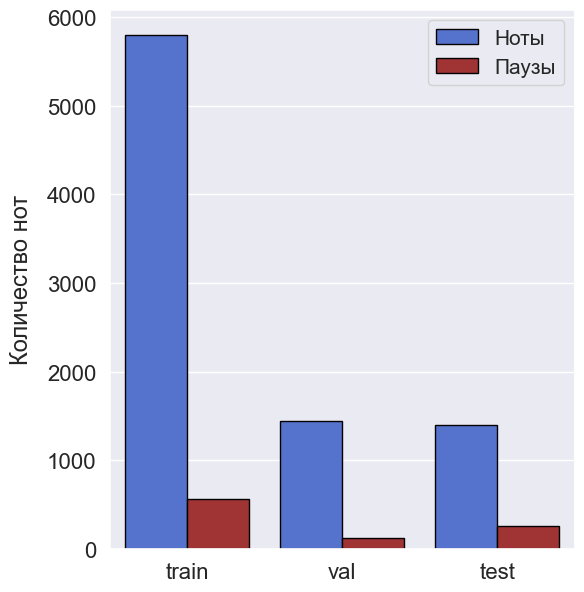

In [9]:
plt.figure(figsize=(FIGSIZE[0] // 3, FIGSIZE[1]))

notes_df = pd.DataFrame({
    'раздел': ['train', 'val', 'test'],
    'количество': [train_stats.total_notes, val_stats.total_notes, test_stats.total_notes],
    'тип': "Ноты"
})

rests_df = pd.DataFrame({
    'раздел': ['train', 'val', 'test'],
    'количество': [train_stats.total_rests, val_stats.total_rests, test_stats.total_rests],
    'тип': "Паузы"
})

df = pd.concat([notes_df, rests_df])

ax = sns.barplot(
    data=df, 
    x='раздел', 
    y='количество',
    hue='тип',
    palette={'Ноты': 'royalblue', 'Паузы': 'firebrick'},
    edgecolor='black',
    alpha=1
)

plt.xlabel("")
plt.ylabel('Количество нот', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)

plt.xticks(fontsize=TICKS_FONTSIZE)
plt.yticks(fontsize=TICKS_FONTSIZE)

plt.legend(title="", fontsize=LEGEND_FONTSIZE)
#plt.title('Распределение количества нот')

plt.show()

# Распределение смещений нот относительно самой низкой ноты

Preprocessing data: 100%|██████████| 356/356 [00:04<00:00, 87.35it/s] 


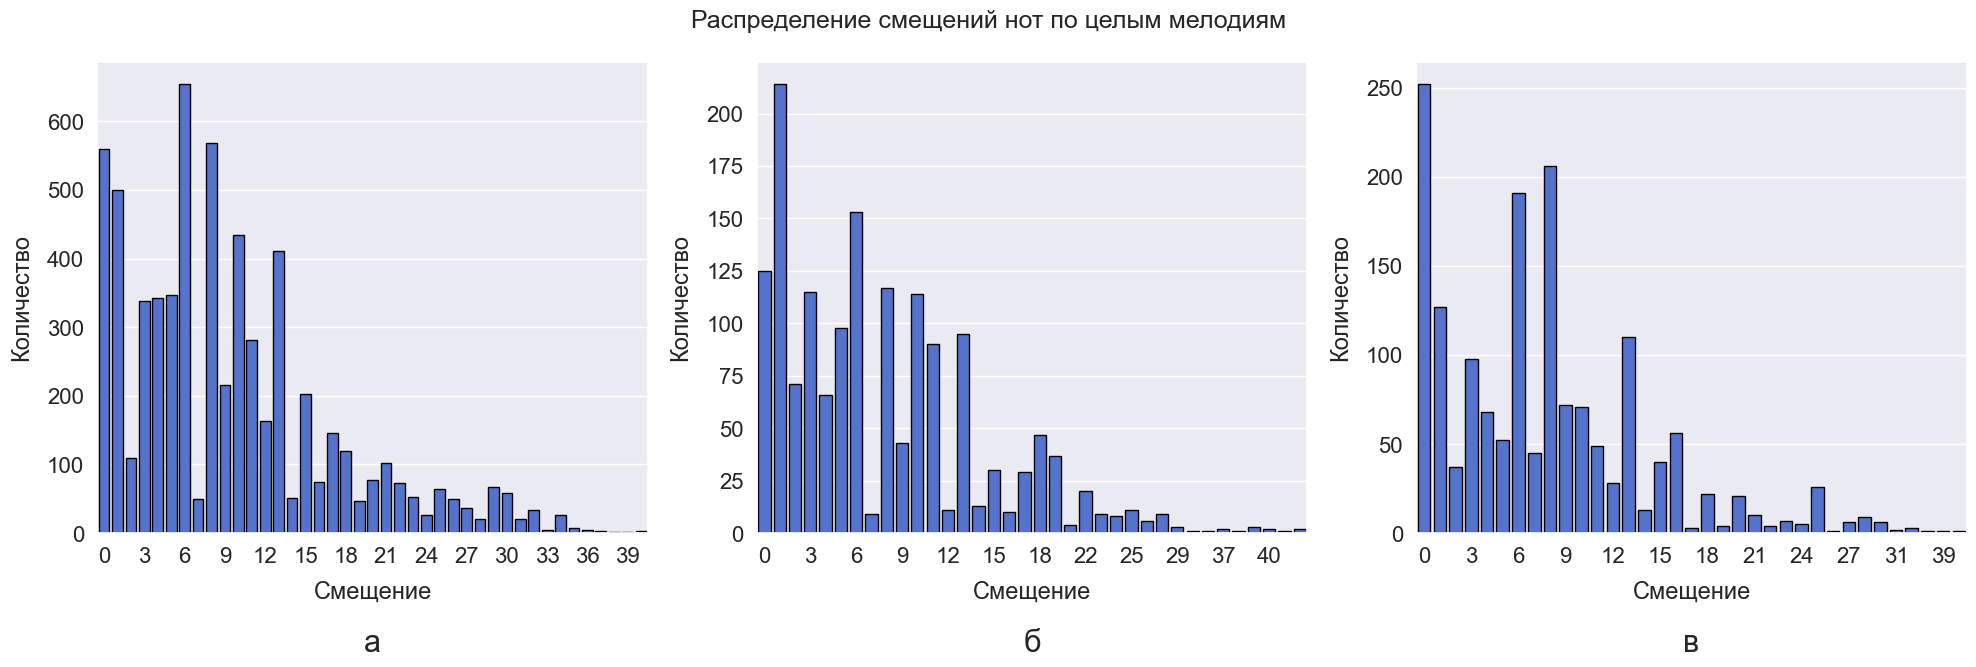

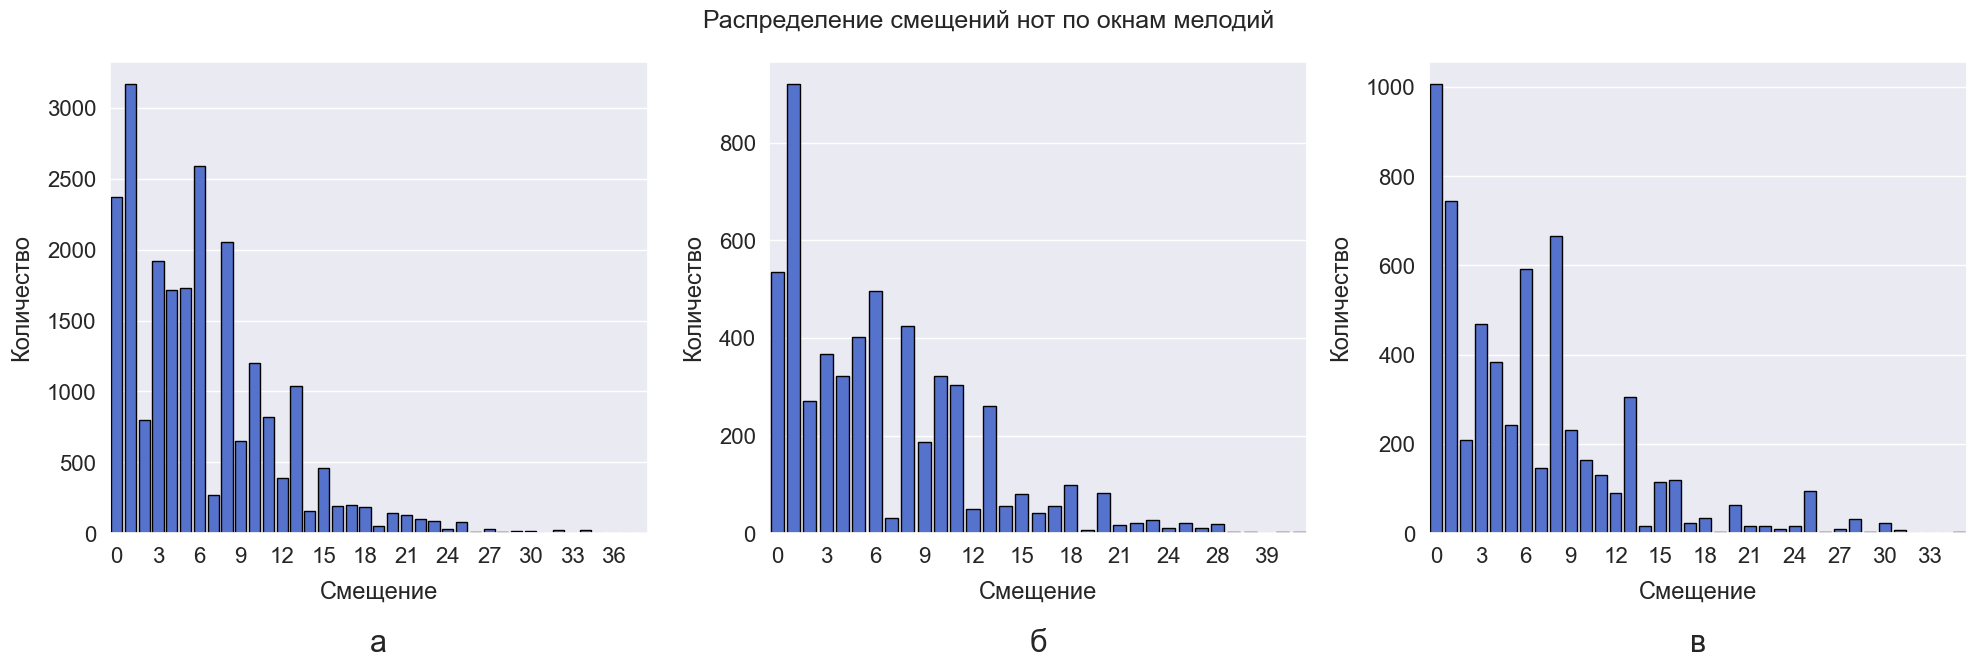

In [10]:
plt.figure(figsize=FIGSIZE)

train_dataset = MelodyDataset.from_path(f"..\\..\\datasets\\MelodyNet\\processed\\train")
val_dataset = MelodyDataset.from_path(f"..\\..\\datasets\\MelodyNet\\processed\\val")
test_dataset = MelodyDataset.from_path(f"..\\..\\datasets\\MelodyNet\\processed\\test")

datasets = [train_dataset, val_dataset, test_dataset]

for i, split in enumerate(['train', 'val', 'test']):
    plt.subplot(1, 3, i + 1)
    
    dataset = datasets[i]
    
    all_offsets = []
    for melody in dataset.melody:
        all_offsets.extend(melody.get_offsets())
    
    offsets_counts = Counter(all_offsets)
    offsets_df = pd.DataFrame.from_dict(offsets_counts, orient='index', columns=['count'])
    offsets_df = offsets_df.reindex(all_offsets).fillna(0)
    offsets_df.index.name = 'offset'
    offsets_df = offsets_df.sort_index()
    offsets_df = offsets_df.reset_index()
    
    ax = sns.barplot(
        data=offsets_df, 
        x='offset', 
        y='count',
        color="royalblue", 
        edgecolor='black',
        alpha=1
    )
    
    plt.xlabel('Смещение', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)
    plt.ylabel('Количество', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)

    locs = ax.get_xticks()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    
    n = 3
    ax.set_xticks(locs[::n])
    ax.set_xticklabels(labels[::n])

    plt.xticks(fontsize=TICKS_FONTSIZE)
    plt.yticks(fontsize=TICKS_FONTSIZE)

    letters = ["а", "б", "в"]
    plt.text(0.5, ENUM_PADDING, f'{letters[i]}', fontsize=ENUM_FONTSIZE, ha='center', transform=plt.gca().transAxes)

    #plt.title(split)

plt.suptitle('Распределение смещений нот по целым мелодиям', fontsize=TITLE_FONTSIZE)
plt.tight_layout()
plt.show()

plt.figure(figsize=FIGSIZE)

for i, split in enumerate(['train', 'val', 'test']):
    plt.subplot(1, 3, i + 1)
    
    dataset = datasets[i]
    
    all_offsets = []
    for melody in dataset.sliced_melody:
        all_offsets.extend(melody.get_offsets())
    
    offsets_counts = Counter(all_offsets)
    offsets_df = pd.DataFrame.from_dict(offsets_counts, orient='index', columns=['count'])
    offsets_df = offsets_df.reindex(all_offsets).fillna(0)
    offsets_df.index.name = 'offset'
    offsets_df = offsets_df.sort_index()
    offsets_df = offsets_df.reset_index()
    
    ax = sns.barplot(
        data=offsets_df, 
        x='offset', 
        y='count',
        color="royalblue", 
        edgecolor='black',
        alpha=1
    )
    
    plt.xlabel('Смещение', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)
    plt.ylabel('Количество', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)

    locs = ax.get_xticks()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    
    n = 3
    ax.set_xticks(locs[::n])
    ax.set_xticklabels(labels[::n])

    plt.xticks(fontsize=TICKS_FONTSIZE)
    plt.yticks(fontsize=TICKS_FONTSIZE)

    letters = ["а", "б", "в"]
    plt.text(0.5, ENUM_PADDING, f'{letters[i]}', fontsize=ENUM_FONTSIZE, ha='center', transform=plt.gca().transAxes)

    #plt.title(split)

plt.suptitle('Распределение смещений нот по окнам мелодий', fontsize=TITLE_FONTSIZE)
plt.tight_layout()
plt.show()

# Распределение интервалов между нотами

Preprocessing data: 100%|██████████| 356/356 [00:04<00:00, 86.52it/s] 


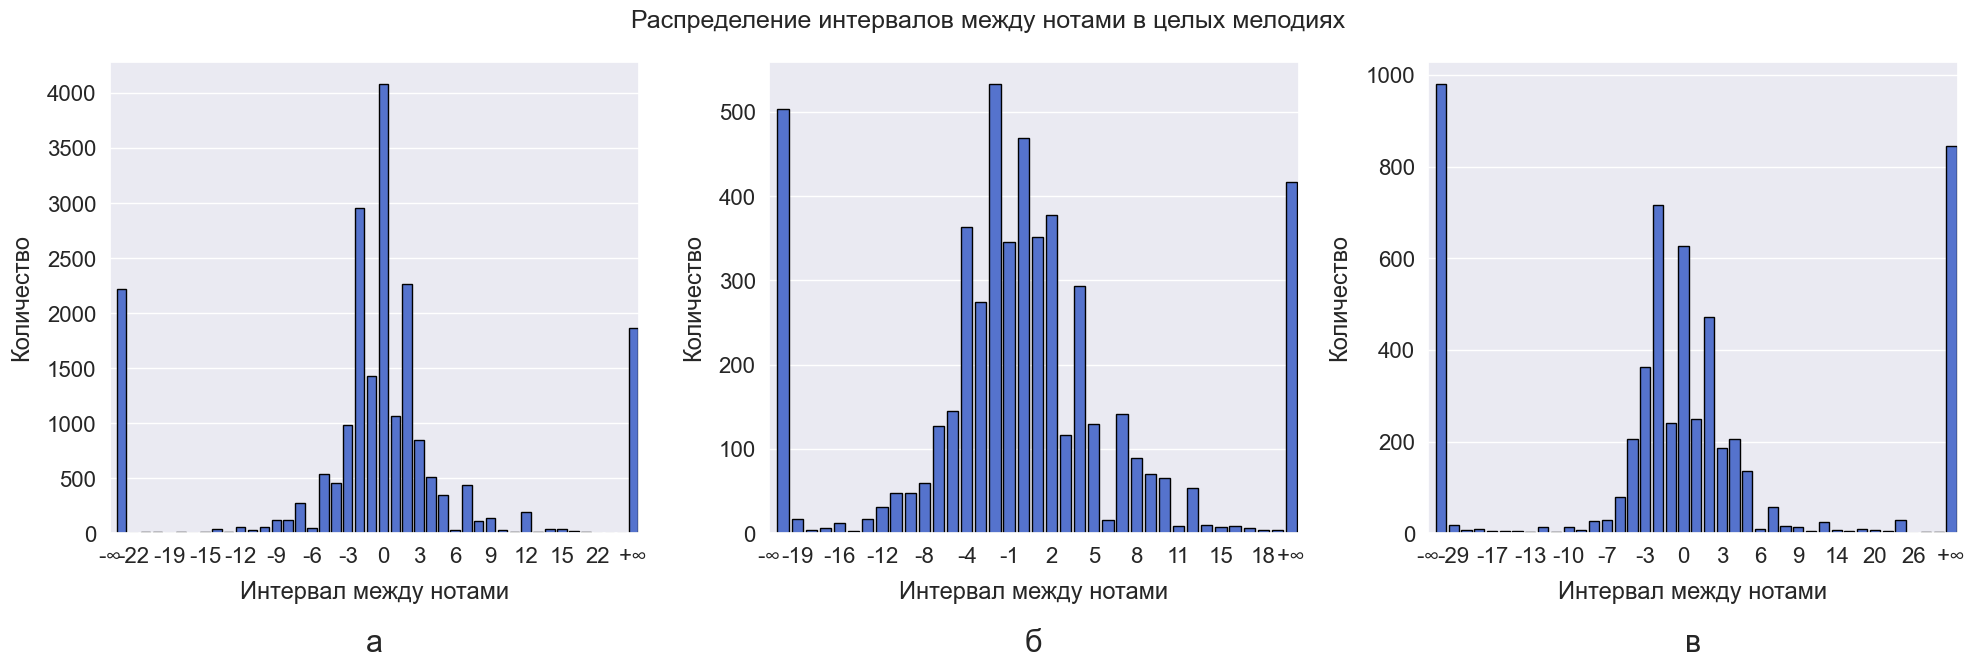

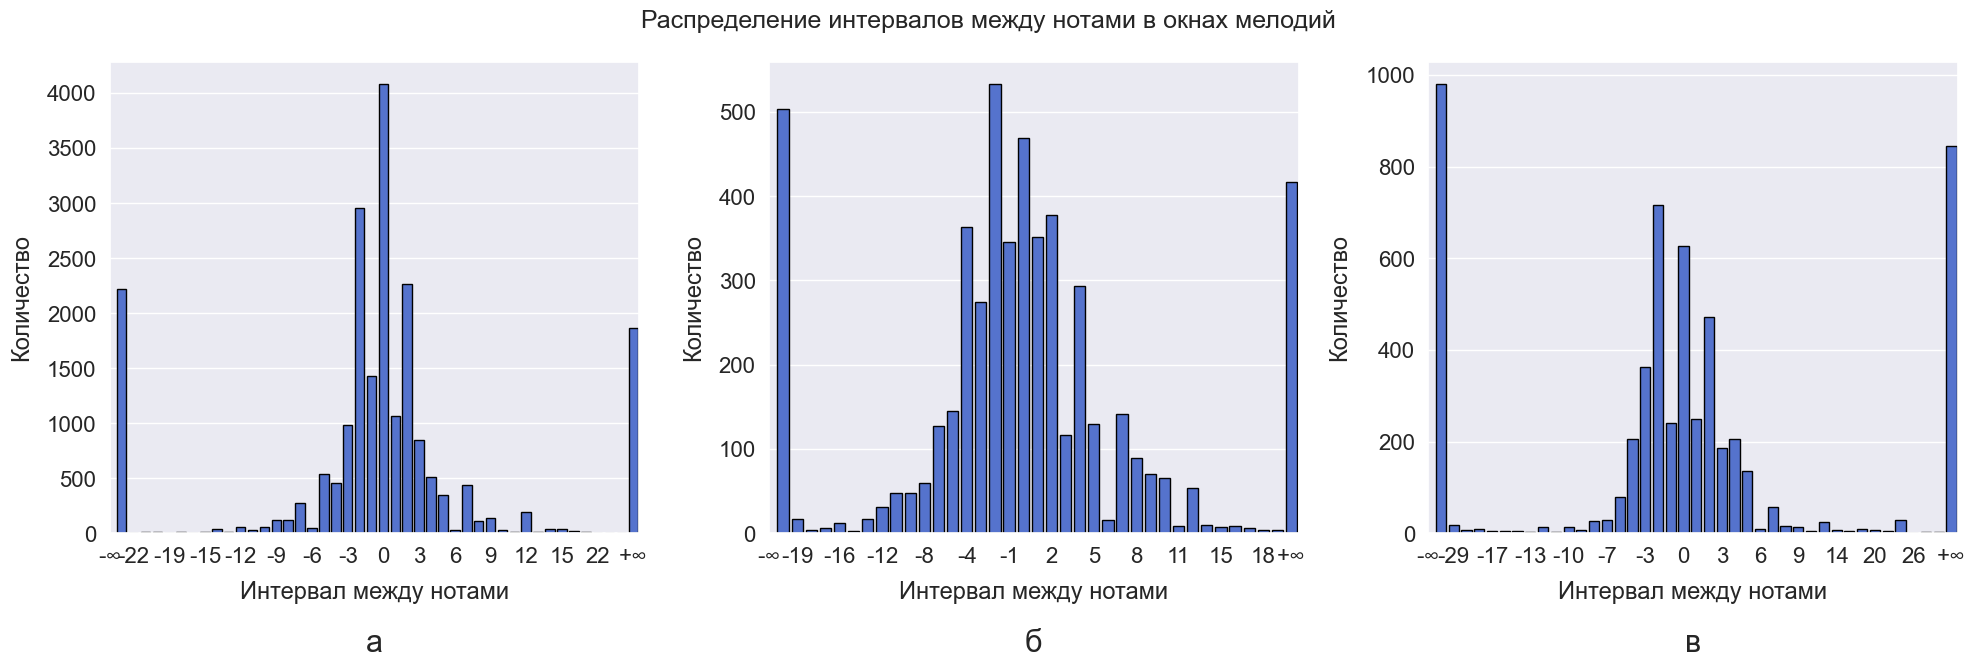

In [11]:
plt.figure(figsize=FIGSIZE)

train_dataset = MelodyDataset.from_path(f"..\\..\\datasets\\MelodyNet\\processed\\train")
val_dataset = MelodyDataset.from_path(f"..\\..\\datasets\\MelodyNet\\processed\\val")
test_dataset = MelodyDataset.from_path(f"..\\..\\datasets\\MelodyNet\\processed\\test")

datasets = [train_dataset, val_dataset, test_dataset]

for i, split in enumerate(['train', 'val', 'test']):
    plt.subplot(1, 3, i + 1)
    
    dataset = datasets[i]
    
    all_intervals = []
    for melody in dataset.sliced_melody:
        all_intervals.extend(melody.get_intervals())
    
    intervals_counts = Counter(all_intervals)
    
    finite_intervals = {k: v for k, v in intervals_counts.items() if not np.isinf(k)}
    finite_intervals = dict(sorted(finite_intervals.items()))
    
    ordered_intervals = {float('-inf'): intervals_counts[float('-inf')]}
    ordered_intervals.update(finite_intervals)
    ordered_intervals[float('inf')] = intervals_counts[float('inf')]
    
    intervals_df = pd.DataFrame.from_dict(ordered_intervals, orient='index', columns=['count'])
    intervals_df.index.name = 'interval'
    intervals_df = intervals_df.reset_index()
    
    intervals_df['interval'] = intervals_df['interval'].apply(
        lambda x: '-∞' if x == float('-inf') else ('+∞' if x == float('inf') else int(x))
    )   
    
    ax = sns.barplot(
        data=intervals_df, 
        x='interval', 
        y='count',
        color="royalblue", 
        edgecolor='black',
        alpha=1
    )
    
    plt.xlabel('Интервал между нотами', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)
    plt.ylabel('Количество', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)
    
    locs = ax.get_xticks()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    
    n = 3
    middle_locs = locs[1:-1:n]
    middle_labels = labels[1:-1:n]
    new_locs = [locs[0]] + list(middle_locs) + [locs[-1]]
    new_labels = [labels[0]] + middle_labels + [labels[-1]]
    
    new_locs[0] -= 1
    ax.set_xticks(new_locs)
    ax.set_xticklabels(new_labels)

    plt.xticks(fontsize=TICKS_FONTSIZE)
    plt.yticks(fontsize=TICKS_FONTSIZE)

    letters = ["а", "б", "в"]
    plt.text(0.5, ENUM_PADDING, f'{letters[i]}', fontsize=ENUM_FONTSIZE, ha='center', transform=plt.gca().transAxes)

    #plt.title(split)

plt.suptitle('Распределение интервалов между нотами в целых мелодиях', fontsize=TITLE_FONTSIZE)
plt.tight_layout()
plt.show()

plt.figure(figsize=FIGSIZE)

for i, split in enumerate(['train', 'val', 'test']):
    plt.subplot(1, 3, i + 1)
    
    dataset = datasets[i]
    
    all_intervals = []
    for melody in dataset.sliced_melody:
        all_intervals.extend(melody.get_intervals())
    
    intervals_counts = Counter(all_intervals)
    
    finite_intervals = {k: v for k, v in intervals_counts.items() if not np.isinf(k)}
    finite_intervals = dict(sorted(finite_intervals.items()))
    
    ordered_intervals = {float('-inf'): intervals_counts[float('-inf')]}
    ordered_intervals.update(finite_intervals)
    ordered_intervals[float('inf')] = intervals_counts[float('inf')]
    
    intervals_df = pd.DataFrame.from_dict(ordered_intervals, orient='index', columns=['count'])
    intervals_df.index.name = 'interval'
    intervals_df = intervals_df.reset_index()
    
    intervals_df['interval'] = intervals_df['interval'].apply(
        lambda x: '-∞' if x == float('-inf') else ('+∞' if x == float('inf') else int(x))
    )   
    
    ax = sns.barplot(
        data=intervals_df, 
        x='interval', 
        y='count',
        color="royalblue", 
        edgecolor='black',
        alpha=1
    )
    
    plt.xlabel('Интервал между нотами', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)
    plt.ylabel('Количество', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)
    
    locs = ax.get_xticks()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    
    n = 3
    middle_locs = locs[1:-1:n]
    middle_labels = labels[1:-1:n]
    new_locs = [locs[0]] + list(middle_locs) + [locs[-1]]
    new_labels = [labels[0]] + middle_labels + [labels[-1]]
    
    new_locs[0] -= 1
    ax.set_xticks(new_locs)
    ax.set_xticklabels(new_labels)

    plt.xticks(fontsize=TICKS_FONTSIZE)
    plt.yticks(fontsize=TICKS_FONTSIZE)

    letters = ["а", "б", "в"]
    plt.text(0.5, ENUM_PADDING, f'{letters[i]}', fontsize=ENUM_FONTSIZE, ha='center', transform=plt.gca().transAxes)

    #plt.title(split)

plt.suptitle('Распределение интервалов между нотами в окнах мелодий', fontsize=TITLE_FONTSIZE)
plt.tight_layout()
plt.show()

# Распределение нот

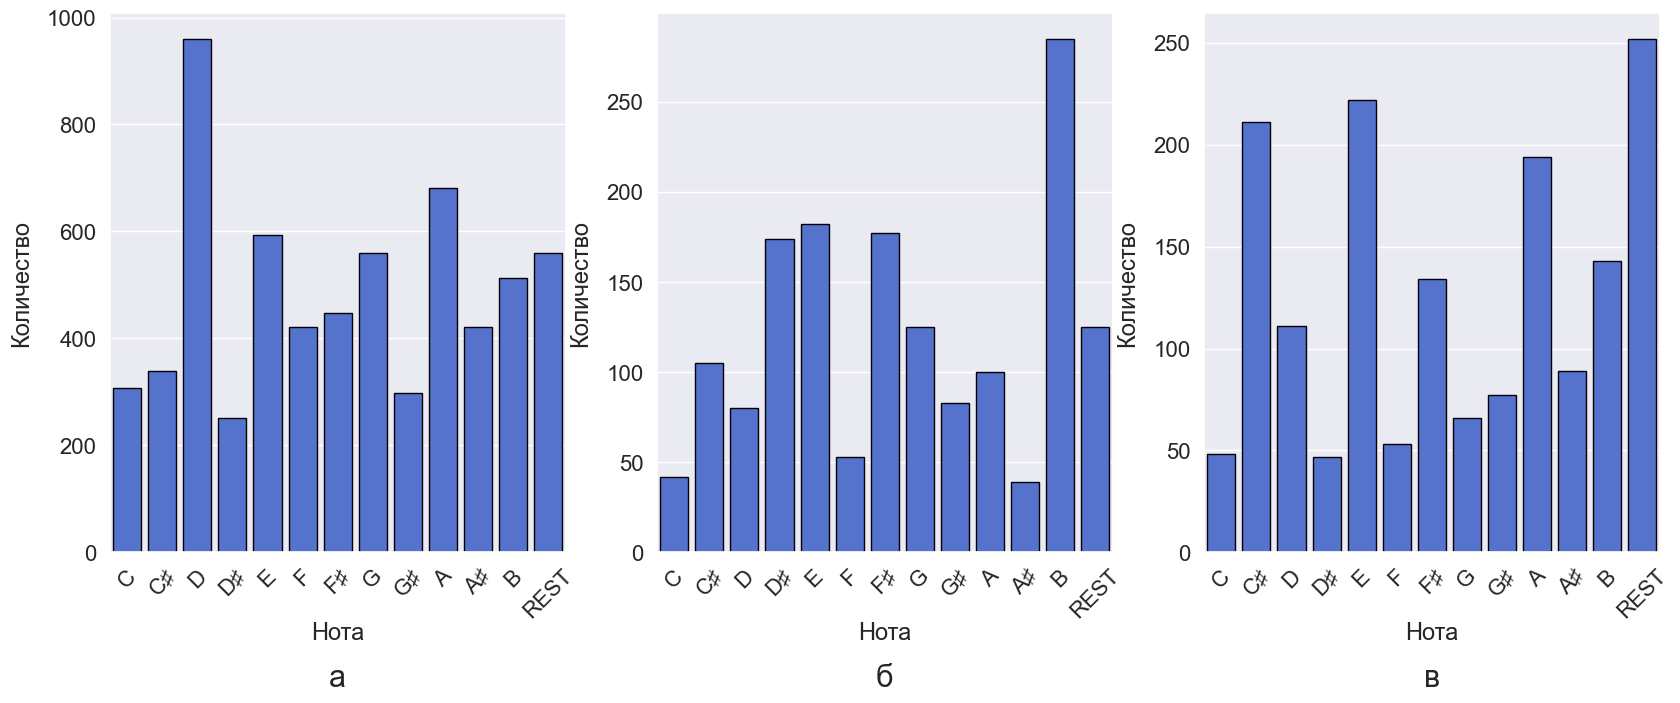

In [12]:
plt.figure(figsize=FIGSIZE)

for i, (stats, label) in enumerate(stats_list):
    plt.subplot(1, 3, i + 1)

    note_counts = Counter(stats.notes)
    note_df = pd.DataFrame.from_dict(note_counts, orient='index', columns=['count'])
    all_labels = Note.PITCH_LABELS + ['REST']
    note_df = note_df.reindex(all_labels).fillna(0)
    note_df.index.name = 'note'
    note_df = note_df.reset_index()

    ax = sns.barplot(
        data=note_df, 
        x='note', 
        y='count',
        color="royalblue", 
        edgecolor='black',
        alpha=1
    )
    
    letters = ["а", "б", "в"]
    plt.text(0.5, ENUM_PADDING, f'{letters[i]}', fontsize=ENUM_FONTSIZE, ha='center', transform=plt.gca().transAxes)

    plt.xlabel('Нота', fontsize=LABELS_FONTSIZE, labelpad=0)
    plt.ylabel('Количество', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)

    plt.xticks(rotation=45, fontsize=TICKS_FONTSIZE)
    plt.yticks(fontsize=TICKS_FONTSIZE)
    
    #plt.title(label)

# Распределение нот по октавам

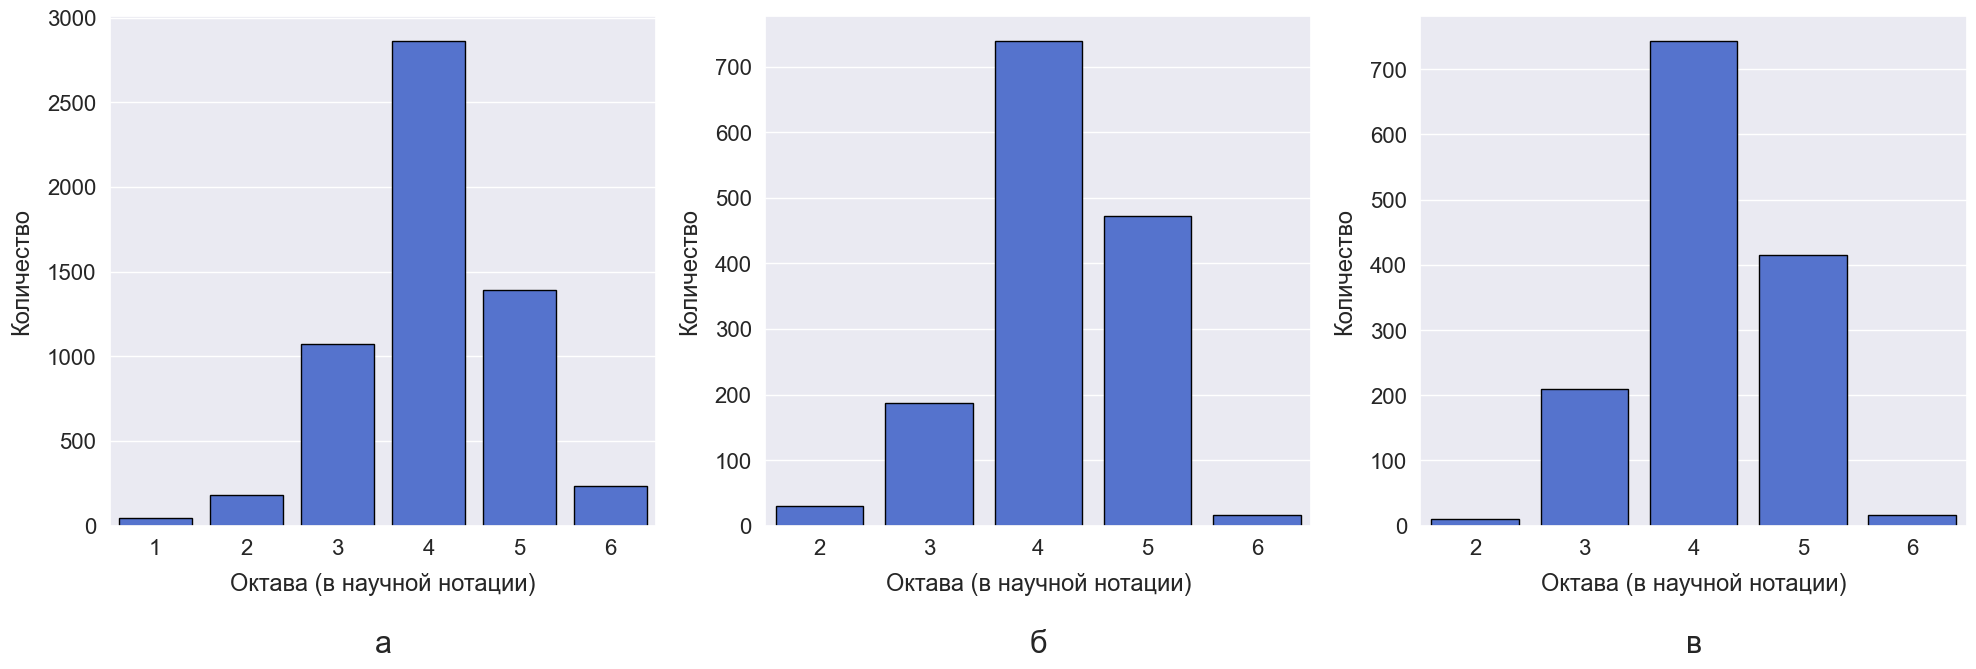

In [13]:
plt.figure(figsize=FIGSIZE)

for i, (stats, label) in enumerate(stats_list):
    plt.subplot(1, 3, i + 1)

    octaves_counts = Counter(stats.octaves)
    octaves_df = pd.DataFrame.from_dict(octaves_counts, orient='index', columns=['count'])
    octaves_df = octaves_df.sort_index()
    octaves_df.index.name = 'octave'
    octaves_df = octaves_df.reset_index()

    ax = sns.barplot(
        data=octaves_df, 
        x='octave', 
        y='count', 
        color="royalblue", 
        edgecolor='black',
        alpha=1
    )

    letters = ["а", "б", "в"]
    plt.text(0.5, ENUM_PADDING, f'{letters[i]}', fontsize=ENUM_FONTSIZE, ha='center', transform=plt.gca().transAxes)

    plt.xlabel('Октава (в научной нотации)', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)
    plt.ylabel('Количество', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)

    plt.xticks(fontsize=TICKS_FONTSIZE)
    plt.yticks(fontsize=TICKS_FONTSIZE)
    
    #plt.title(label)

#plt.suptitle('Распределение нот по октавам', fontsize=TITLE_FONTSIZE)
plt.tight_layout()
plt.show()

# Распределение длительностей нот и пауз

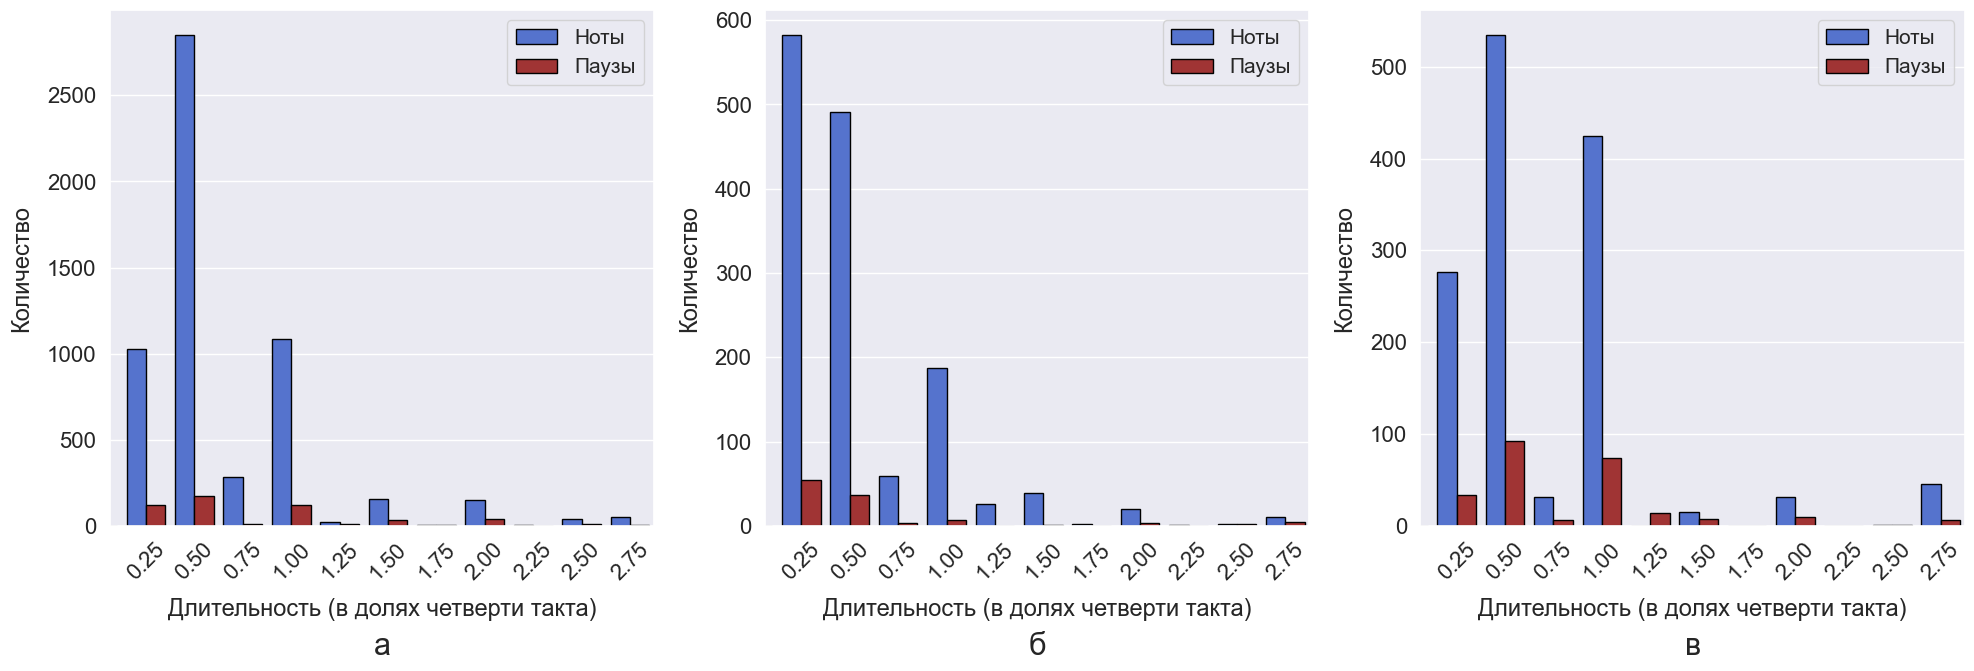

In [14]:
plt.figure(figsize=FIGSIZE)

for i, (stats, label) in enumerate(stats_list):
    plt.subplot(1, 3, i + 1)

    max_duration = 3
    step = 0.25
    bins = np.arange(0, max_duration + step, step)
    
    filtered_notes = [d for d in stats.note_durations if 0 < d <= max_duration]
    filtered_rests = [d for d in stats.rest_durations if 0 < d <= max_duration]

    notes_hist, _ = np.histogram(filtered_notes, bins=bins)
    rests_hist, _ = np.histogram(filtered_rests, bins=bins)

    notes_df = pd.DataFrame({
        'Длительность': bins[:-1],
        'Количество': notes_hist,
        'Тип': 'Ноты'
    })
    
    rests_df = pd.DataFrame({
        'Длительность': bins[:-1],
        'Количество': rests_hist,
        'Тип': 'Паузы'
    })
    
    df = pd.concat([notes_df, rests_df])

    ax = sns.barplot(
        data=df,
        x='Длительность',
        y='Количество',
        hue='Тип',
        palette={'Ноты': 'royalblue', 'Паузы': 'firebrick'},
        edgecolor='black'
    )

    letters = ["а", "б", "в"]
    plt.text(0.5, ENUM_PADDING, f'{letters[i]}', fontsize=ENUM_FONTSIZE, ha='center', transform=plt.gca().transAxes)

    plt.xlabel('Длительность (в долях четверти такта)', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)
    plt.ylabel('Количество', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)

    plt.xticks(range(len(bins[:-1])), [f'{x:.2f}' for x in bins[:-1]], rotation=45, fontsize=TICKS_FONTSIZE)
    plt.yticks(fontsize=TICKS_FONTSIZE)

    plt.xlim(left=0.25)

    #plt.title(label)
    plt.legend(title='', fontsize=LEGEND_FONTSIZE)

#plt.suptitle('Распределение длительностей нот и пауз', fontsize=TITLE_FONTSIZE)
plt.tight_layout()
plt.show()

# Распределение длительностей мелодий

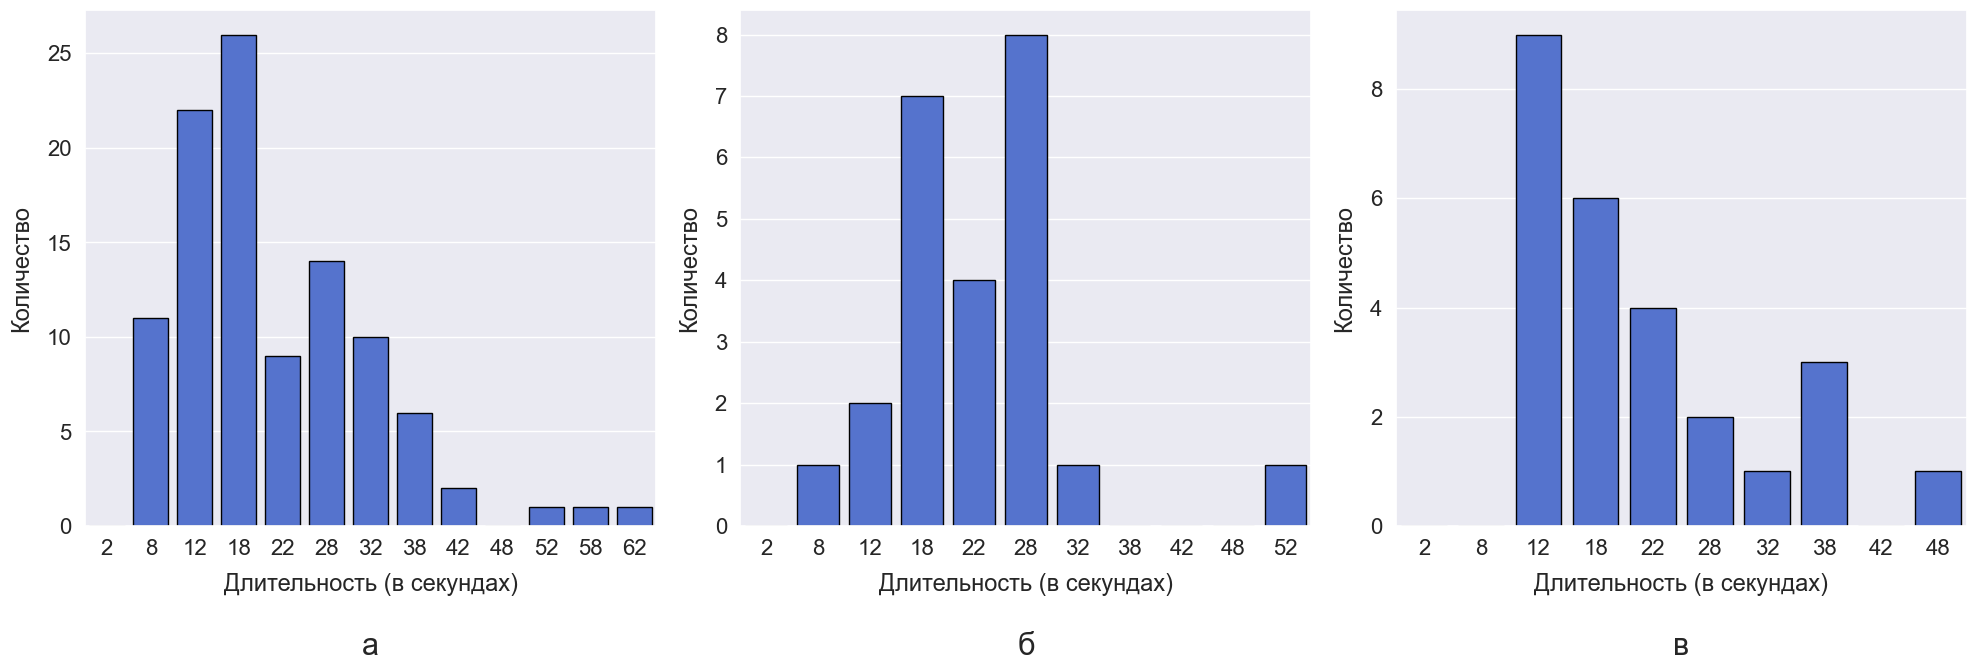

In [15]:
plt.figure(figsize=FIGSIZE)

for i, (stats, label) in enumerate(stats_list):
    plt.subplot(1, 3, i + 1)

    # Подготовка данных для barplot
    bins = np.arange(0, max(stats.melody_durations) + 5, 5)
    hist, edges = np.histogram(stats.melody_durations, bins=bins)
    bin_centers = (edges[:-1] + edges[1:]) / 2

    df_plot = pd.DataFrame({
        'Длительность': bin_centers,
        'Количество': hist
    })

    ax = sns.barplot(
        data=df_plot,
        x='Длительность',
        y='Количество',
        color='royalblue',
        edgecolor='black',
        alpha=1
    )
    
    letters = ["а", "б", "в"]
    plt.text(0.5, ENUM_PADDING, f'{letters[i]}', fontsize=ENUM_FONTSIZE, ha='center', transform=plt.gca().transAxes)

    plt.xlabel('Длительность (в секундах)', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)
    plt.ylabel('Количество', fontsize=LABELS_FONTSIZE, labelpad=LABELS_PAD)

    plt.xticks(range(len(bin_centers)), [f'{x:.0f}' for x in bin_centers], fontsize=TICKS_FONTSIZE)
    plt.yticks(fontsize=TICKS_FONTSIZE)

    #plt.title(label)

#plt.suptitle('Распределение длительностей мелодий', fontsize=TITLE_FONTSIZE)
plt.tight_layout()
plt.show()